In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime
sns.set()

compare states relevant to my life

check out the current surge in cases in florida, texas, california, georgia, etc. 

"debate" over quarantine measures

## Data quality related exploration

    Differences in reporting 
    differences in time series.


## COVID related exploration

    Death rate estimation. 
    testing vs cases vs deaths
    log-log plot for current growth trends
    bollinger bands
    Differences in government responses (early vs late)
    histogram of trending upwards, flat, downwards
    tools, different plots, correlation plots scatter matrix plots. 

Explorations and questions to answer

Get a feel for the important features such as new cases per million per day. 

The origins of the pandemic and the dates of first cases/tests etc. 

People feel like debating quarantine measures so I will investigate:
    
    The relationship between the "reaction time" of government responses and death rate.
    The effect of last month's government strictness vs. the number of new cases today. 
    
The current state of the world (countries with most rampant spread) moving average
and standard deviation time series plots.

In [2]:
def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

    
def intersect_indexes(df1,df2,level=0):
    intersection = df1.index.get_level_values(level).intersection(df2.index.get_level_values(level))
    return df1.loc[intersection], df2.loc[intersection]


def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

In [3]:
def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        rollstd = None
        print(features, roll_widths)
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
                rollstd = df.loc[c, features].rolling(window).std().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
                rollstd = pd.concat((rollstd,  df.loc[c,features].rolling(window).std().fillna(value=0.)),axis=0)

        new_features = pd.concat((rollmean, rollstd), axis=1)
#         new_features = rollmean
#         new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         new_cols = mean_cols

        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)

def compare_ma_std_series(data, feature_names, location_list, scale=None):   
    fig, ax = plt.subplots(figsize=(10,5))
    roll_mean_name, roll_std_name = feature_names

    roll_width = [char for char in roll_mean_name][-1]
    feature = roll_mean_name.split('_rolling')[0]
    data_plot = data.copy()
    data_plot = data_plot.set_index('date')
    label_increment =(data_plot.time_index.max()-data_plot.time_index.min())//5
    for location in location_list:
        location_df = data_plot[data_plot.location==location]
        rollmean = location_df.loc[:, roll_mean_name].values
        rollstd = location_df.loc[:, roll_std_name].values
        lower = rollmean - rollstd
        lower[lower<0] = 0
        upper = rollmean + rollstd
        cis = (lower, upper)
        ax.fill_between(range(len(location_df)), cis[0], cis[1], alpha=0.1)
        ax.plot(range(len(location_df)), rollmean,
                        label=location)
        plt.title((feature+' {}-day MA +- {}-day STD ').format(roll_width,roll_width))
        _ = ax.set_ylabel(feature)
        _ = ax.set_xlabel('Date')
        _ = ax.set_xticks(range(0,len(location_df),label_increment))
        _ = ax.set_xticklabels(location_df.index[::label_increment].date)
        ax.grid(True)
    plt.legend(loc='upper left')
    if scale == 'log':
        ax.set_yscale('log')
    _ = plt.show()
    return None

def compare_time_series(data, feature, location_list, scale=None):     
    fig, ax = plt.subplots(figsize=(10,5))
    data_plot = data.copy()
    data_plot = data_plot.set_index('date')
    label_increment =(data_plot.time_index.max()-data_plot.time_index.min())//5
    for location in location_list:
        location_df = data_plot[(data_plot.location==location)]
        time_series = location_df.loc[:, feature]
        ax.plot(range(len(location_df)), time_series, label=location)
        plt.title(feature+' comparison')
        _ = ax.set_ylabel(feature)
        _ = ax.set_xlabel('Date')
        _ = ax.set_xticks(range(0,len(location_df),label_increment))
        _ = ax.set_xticklabels(location_df.index[::label_increment].date)
        ax.grid(True)
    if scale == 'log':
        ax.set_yscale('log')
    plt.legend(loc='upper left')
    _ = plt.show()

    return None
        

In [4]:
data = pd.read_csv('data.csv', index_col=0)
data = data[data.location!='World']
data.loc[:, 'time_index'] += 1
data.loc[:, 'date'] = pd.to_datetime(data.date).dt.normalize().values

Although Italy had a similar number of cases per million as the United States (and earlier on, when less information on the disease was out), their reaction and subsequent actions quelled the pandemic. As can be seen, the United States did not control the pandemic enough, leading to a much smaller decrease followed by an increase in the number of cases per million.

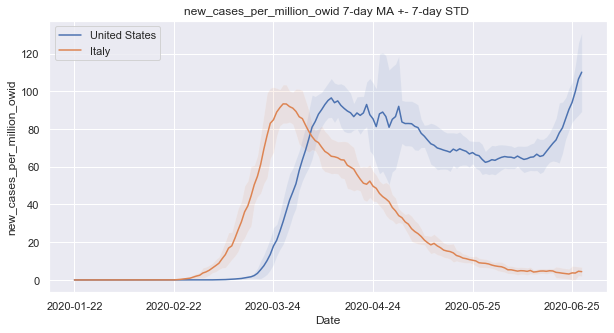

In [5]:
names = ('new_cases_per_million_owid_rolling_mean_7', 'new_cases_per_million_owid_rolling_std_7')
compare_ma_std_series(data, names, ['United States', 'Italy'])

To analyze what was done differently, I look towards Oxford's stringency index, which quantifies the government strictness of each country. The Italian government was much more strict when their cases per million was peaking, which allowed for them to loosen restrictions sooner, once the pandemic was under control. I investigate later on the relation between this stringency index and other important quantities.

location
Italy            62.427891
United States    49.782194
dtype: float64


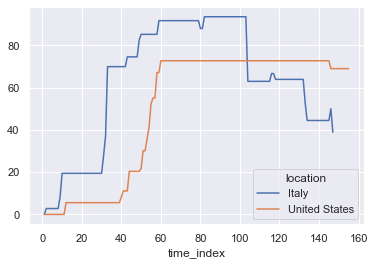

In [6]:
ITA_USA_stringency = data[data.location.isin( ['United States', 'Italy'])].set_index(['time_index','location']).stringency_index_oxcgrt.unstack()
ITA_USA_stringency.plot()
print(ITA_USA_stringency.mean())

# Introduction <a id='intro'></a>

This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 


## Exploratory Data Analysis<a id='EDA'></a>
Ideas for the inclusion or creation of new columns.

Moving averages
fourier
signal
flags for lots of different things

MI vs GA

hardest hit countries

days since

which dataset it came from

distribution of initial tests, responses, cases dates.

humans view, interpret and forecast things in a way which are not available to robots. 
data driven, time dependent manner of modeling. Really trying to encapsulate the time dependence. 

I'm electing to fill the time independent features which are ***still*** missing with the median of ***all*** current values; otherwise I would have to drop them because of the missing values. This is ok? perhaps? It's hard to justify. 

Because the features I will be predicting are all measured per million people, it seems unwise to include
very small countries and microstates such as San Marino; whose small population makes them has the maximum 
value in all quantities measured "per million". In other words, I want to normalize by population but the
dynamics of these small states seems to be fundamentally different due to size.

To get an idea as to the spread of COVID-19, look at the distribution of the first recorded cases, deaths, and tests of all locations.

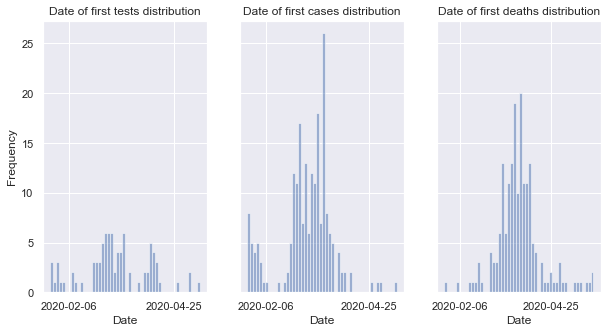

In [7]:
labelstart = 15
label_increment = (data.time_index.max() - data.time_index.min())//2

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5), sharey=True)
first_dates_temp = data.replace(to_replace=0., value=np.nan)
first_tests = data.loc[first_dates_temp.total_tests_owid.dropna().index,:].groupby('location').time_index.min()
first_cases =  data.loc[first_dates_temp.total_cases_owid.dropna().index,:].groupby('location').time_index.min()
first_deaths = data.loc[first_dates_temp.total_deaths_owid.dropna().index,:].groupby('location').time_index.min()
first_tests.plot.hist(alpha=0.5, bins=50, ax=ax1)
first_cases.plot.hist(alpha=0.5, bins=50, ax=ax2)
first_deaths.plot.hist(alpha=0.5, bins=50, ax=ax3)

_ = ax1.set_xlabel('Date')
_ = ax1.set_title('Date of first tests distribution')
_ = ax1.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax1.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax2.set_xlabel('Date')
_ = ax2.set_title('Date of first cases distribution')
_ = ax2.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax2.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax3.set_xlabel('Date')
_ = ax3.set_title('Date of first deaths distribution')
_ = ax3.set_xticks(range(labelstart, data.time_index.max(),label_increment))
_ = ax3.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

The middle of the date range corresponds to the month of March, indicating that most countries experienced their first (recorded) cases around that month.

To get an idea as to the current severity of the global pandemic, look at the countries with highest numbers of cases and deaths, see if these countries are indeed testing sufficiently (i.e. the countries with highest tests would hopefully be the same).

In [8]:
today = time_slice(data,-1,-1)

today.loc[:, ['location', 'new_cases_owid']].sort_values(by='new_cases_owid').dropna()[-10:]

,location,new_cases_owid
32117,Pakistan,4072.0
8108,Colombia,4149.0
7790,Chile,4406.0
26075,Mexico,4410.0
1748,Argentina,5287.0
34820,Russia,6852.0
38000,South Africa,7210.0
18284,India,19906.0
5246,Brazil,38693.0
43724,United States,42486.0


In [9]:
today.loc[:, ['location', 'new_tests_owid']].sort_values(by='new_tests_owid').dropna()[-10:]

,location,new_tests_owid
34661,Romania,17650.0
3338,Bangladesh,18099.0
32117,Pakistan,25013.0
19079,Iran,27327.0
20033,Italy,37346.0
6995,Canada,42072.0
2543,Australia,43114.0
42452,Turkey,45213.0
18284,India,231095.0
34820,Russia,337008.0


In [10]:
today.loc[:, ['location', 'new_deaths_owid']].sort_values(by='new_deaths_owid').dropna()[-10:]

,location,new_deaths_owid
19397,Iraq,101.0
8108,Colombia,128.0
34820,Russia,188.0
33071,Peru,196.0
19079,Iran,234.0
7790,Chile,279.0
18284,India,410.0
43724,United States,500.0
26075,Mexico,602.0
5246,Brazil,1109.0


In [11]:
top_10_locations_most_cases = today.set_index('location').new_cases_owid.dropna().sort_values()[-10:].index
top_10_locations_most_tests = today.set_index('location').new_tests_owid.dropna().sort_values()[-10:].index
top_10_locations_most_deaths = today.set_index('location').new_deaths_owid.dropna().sort_values()[-10:].index

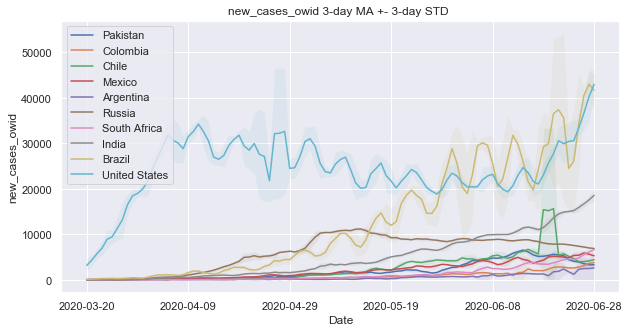

In [12]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_cases_owid_rolling_mean_3','new_cases_owid_rolling_std_3'), 
                      top_10_locations_most_cases)

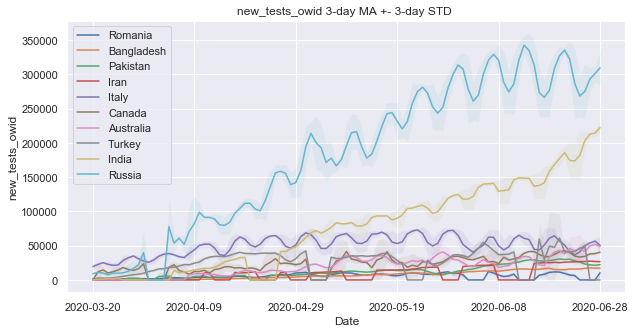

In [13]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_tests_owid_rolling_mean_3','new_tests_owid_rolling_std_3'), 
                      top_10_locations_most_tests)

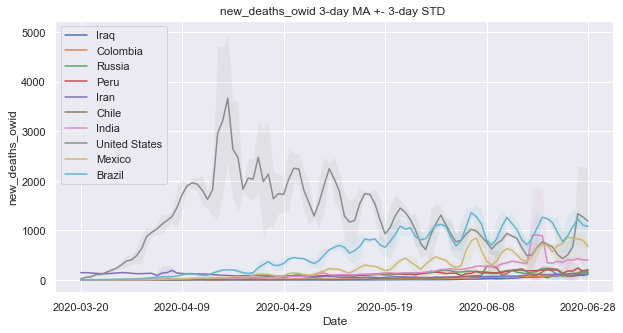

In [14]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_deaths_owid_rolling_mean_3','new_deaths_owid_rolling_std_3'), 
                      top_10_locations_most_deaths)

The countries which are in the top 10 cases but are not in the top ten of tests are probably not testing enough;

In [15]:
print('The countries which should likely test more are')
print(top_10_locations_most_cases[~top_10_locations_most_cases.isin(top_10_locations_most_tests)].tolist())

The countries which should likely test more are
['Colombia', 'Chile', 'Mexico', 'Argentina', 'South Africa', 'Brazil', 'United States']


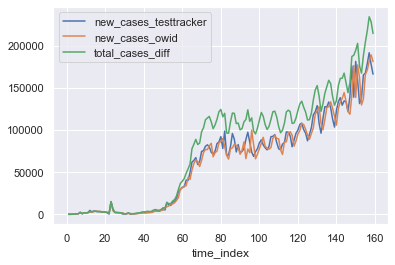

In [16]:
data.loc[:, column_search(data,'new_cases')[:2].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_cases.diff(1).fillna(0)
).plot(legend=True, label='total_cases_diff')
# .plot()

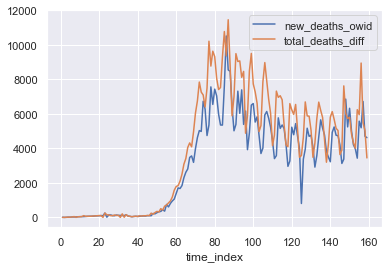

In [17]:
data.loc[:, column_search(data,'new_deaths')[:1].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_deaths.diff(1).fillna(0)
).plot(legend=True, label='total_deaths_diff')
# .plot()

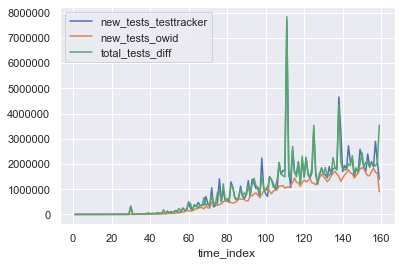

In [18]:
data.loc[:, column_search(data,'new_tests')[:2]].groupby(data.time_index).sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_tests.diff(1).fillna(0)
).plot(legend=True, label='total_tests_diff')

In [19]:
locations_with_population_info = data.loc[data.population_owid.dropna().index,:]
locations_with_population_info.loc[:, 'cases_per_million'] = locations_with_population_info.total_cases / (locations_with_population_info.population_owid/1000000.)
locations_with_population_info = locations_with_population_info[locations_with_population_info.location!='Yemen']
locations_with_population_info = locations_with_population_info.set_index('location')#.cases_per_million

The stringency index of the next to last month is affected by the number of cases (per million), to capture this dependence,
take the statistic and divide it by the number of cases per million at the beginning of this month. Then, look at the number of new cases per million in the last month. I.e. take the statistic between T-60 and T-30, then normalize  by cases per million at T-60, then look at the new number of cases per million at T-30 (ratio or difference). If the normalization by T-60 cases per million is unjustified then the results do not hold; there seems to be no relationship of significance in that case.

In [20]:
neg_30_cases = time_slice(locations_with_population_info,-30, -30).total_cases
neg_30_cases_per_million = time_slice(locations_with_population_info, -30, -30).cases_per_million
neg_30_cases_per_million = neg_30_cases_per_million[neg_30_cases_per_million>0]
neg_30_cases = neg_30_cases[neg_30_cases>0]

In [21]:
present_cases_per_million = time_slice(locations_with_population_info, -1, -1).cases_per_million

In [22]:
next_to_last_month_cases_per_million = time_slice(locations_with_population_info, -60, -30).cases_per_million
# next_to_last_month_cases_per_million = next_to_last_month_cases_per_million.groupby('location').mean()
next_to_last_month_stringency= time_slice(locations_with_population_info,-60,-30).stringency_index_oxcgrt
# next_to_last_month_cases_per_million = next_to_last_month_cases_per_million.groupby('location').mean()
next_to_last_max = next_to_last_month_stringency.groupby(level=0).max()
next_to_last_mean = next_to_last_month_stringency.groupby(level=0).mean()

neg_60_cases = time_slice(locations_with_population_info,-60, -60).total_cases
neg_60_cases_per_million = time_slice(locations_with_population_info, -60, -60).cases_per_million
neg_60_cases_per_million = neg_60_cases_per_million[neg_60_cases_per_million>0]
neg_60_cases = neg_60_cases[neg_60_cases>0]
neg_60_cases, next_to_last_max =  intersect_indexes(neg_60_cases.dropna(), next_to_last_max.dropna(), level=0)

case_differential = present_cases_per_million-neg_30_cases_per_million
case_differential = case_differential[case_differential>0]
case_ratio = case_differential / neg_30_cases_per_million

log_case_differential = np.log10(case_differential+1)
log_case_ratio = np.log10(case_ratio+1)

max_severity_ratio = next_to_last_max/neg_60_cases
mean_severity_ratio= next_to_last_mean/neg_60_cases

max_severity_ratio_per_million = next_to_last_max/neg_60_cases_per_million
mean_severity_ratio_per_million = next_to_last_mean/neg_60_cases_per_million
log_mean_severity_ratio =  np.log10(mean_severity_ratio + 1)
log_max_severity_ratio =  np.log10(max_severity_ratio + 1)
log_mean_severity_ratio_per_million =  np.log10(mean_severity_ratio_per_million + 1)
log_max_severity_ratio_per_million=  np.log10(max_severity_ratio_per_million + 1)

# y = (present_cases_per_million-neg_30_cases_per_million)#/neg_30_cases_per_million

number of cases per million affects the next month stringency which affects next month change in cases.

0.009569749561025994


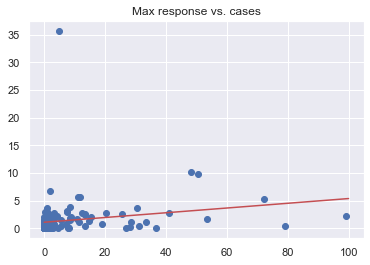

In [23]:
case_differential = (present_cases_per_million-neg_30_cases_per_million ) / neg_30_cases_per_million
y = case_differential
x = next_to_last_max / neg_60_cases_per_million

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

# y= (present_cases_per_million-next_to_last_month_cases_per_million)/next_to_last_month_cases_per_million
# y = np.log((100*(present_cases_per_million)/next_to_last_month_cases_per_million)+1)
# y = present_cases_per_million-start_cases_per_million

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)

0.005468359780875186


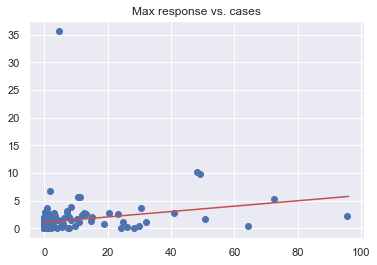

In [24]:
case_differential = (present_cases_per_million-neg_30_cases_per_million )/neg_30_cases_per_million
y = case_differential
x = next_to_last_mean / neg_60_cases_per_million

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

# y= (present_cases_per_million-next_to_last_month_cases_per_million)/next_to_last_month_cases_per_million
# y = np.log((100*(present_cases_per_million)/next_to_last_month_cases_per_million)+1)
# y = present_cases_per_million-start_cases_per_million

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)

0.01878466028592696


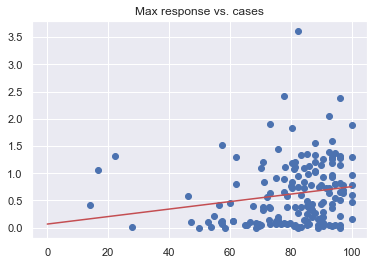

In [25]:
case_differential = (present_cases_per_million-neg_30_cases_per_million )/neg_30_cases_per_million
y = np.log(case_differential+1)
x = next_to_last_max

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

# y= (present_cases_per_million-next_to_last_month_cases_per_million)/next_to_last_month_cases_per_million
# y = np.log((100*(present_cases_per_million)/next_to_last_month_cases_per_million)+1)
# y = present_cases_per_million-start_cases_per_million

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)

0.000219321125445517


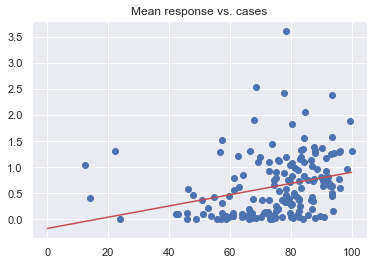

In [26]:
case_differential = (present_cases_per_million-neg_30_cases_per_million )/neg_30_cases_per_million
y = np.log(case_differential+1)
x = next_to_last_mean

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

# y= (present_cases_per_million-next_to_last_month_cases_per_million)/next_to_last_month_cases_per_million
# y = np.log((100*(present_cases_per_million)/next_to_last_month_cases_per_million)+1)
# y = present_cases_per_million-start_cases_per_million

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Mean response vs. cases')
ax.grid(True)
print(p_value)

In [27]:
states = pd.read_csv('jhucsse_usa.csv').location.unique()
usa_data = data[data.location.isin(states.tolist())].set_index(['time_index','location'])
usa_data.loc[:, 'new_cases_jhucsse_usa'] = usa_data.groupby(level=1).cases_jhucsse_usa.diff(1).fillna(0).values
usa_data.loc[:, 'new_deaths_jhucsse_usa'] = usa_data.groupby(level=1).deaths_jhucsse_usa.diff(1).fillna(0).values
usa_data = usa_data.reset_index()

In [28]:
ten_states_with_most_new_cases = time_slice(usa_data,-1,-1).set_index('location').new_cases_jhucsse_usa.sort_values()[-10:].index

In [29]:
new_features = rolling_features(usa_data, ['new_cases_jhucsse_usa','new_deaths_jhucsse_usa'], [3])
usa_data = pd.concat((usa_data, new_features),axis=1)
# usa_data = usa_data.reset_index()

['new_cases_jhucsse_usa', 'new_deaths_jhucsse_usa'] [3]


In [30]:
feature_names = ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3')
location_list = ten_states_with_most_new_cases.tolist()

In [31]:
usa_data[usa_data.time_index>120]

,time_index,location,date,cases_jhucsse,deaths_jhucsse,cases_jhucsse_usa,deaths_jhucsse_usa,new_tests_testtracker,tests_cumulative_testtracker,tests_per100k_testtracker,...,new_total_tests_per_thousand_owid_per_million,new_total_deaths_per_million,new_total_cases_per_million,new_total_tests_per_million,new_cases_jhucsse_usa,new_deaths_jhucsse_usa,new_cases_jhucsse_usa_rolling_mean_3,new_deaths_jhucsse_usa_rolling_mean_3,new_cases_jhucsse_usa_rolling_std_3,new_deaths_jhucsse_usa_rolling_std_3
120,121,Alabama,2020-05-21,NaN,NaN,13288.0,529.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,236.0,7.0,400.666667,13.333333,239.969442,5.686241
121,122,Alabama,2020-05-22,NaN,NaN,13670.0,541.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,382.0,12.0,431.333333,12.333333,224.110092,5.507571
122,123,Alabama,2020-05-23,NaN,NaN,14117.0,549.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,447.0,8.0,355.000000,9.000000,108.060168,2.645751
123,124,Alabama,2020-05-24,NaN,NaN,14478.0,551.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,361.0,2.0,396.666667,7.333333,44.836741,5.033223
124,125,Alabama,2020-05-25,NaN,NaN,14986.0,566.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,508.0,15.0,438.666667,8.333333,73.853459,6.506407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,155,Wyoming,2020-06-24,NaN,NaN,1282.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,28.0,0.0,28.333333,0.000000,4.509250,0.000000
8900,156,Wyoming,2020-06-25,NaN,NaN,1326.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44.0,0.0,32.000000,0.000000,10.583005,0.000000
8901,157,Wyoming,2020-06-26,NaN,NaN,1368.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,42.0,0.0,38.000000,0.000000,8.717798,0.000000
8902,158,Wyoming,2020-06-27,NaN,NaN,1392.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,24.0,0.0,36.666667,0.000000,11.015141,0.000000


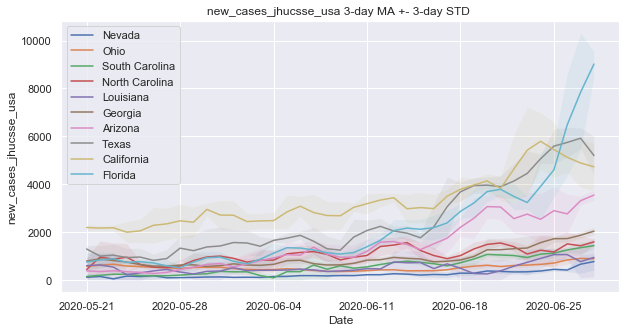

In [32]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist())
# plt.legend(loc=(1.2,0))

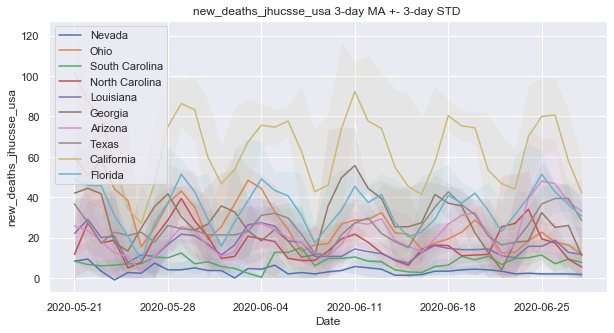

In [33]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_deaths_jhucsse_usa_rolling_mean_3','new_deaths_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist())
# plt.legend(loc=(1.2,0))

In [34]:
hospitalization = pd.read_csv('./ihme/Hospitalization_all_locs.csv', index_col=0).reset_index(drop=True)
hospitalization

,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,...,totdea_lower_smoothed,totdea_upper_smoothed,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
0,Abruzzo,2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
1,Abruzzo,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
2,Abruzzo,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
3,Abruzzo,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
4,Abruzzo,2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,observed,6.127576,observed,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52294,Zacatecas,2020-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52295,Zacatecas,2020-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52296,Zacatecas,2020-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52297,Zacatecas,2020-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
summary_stats = pd.read_csv('./ihme/Summary_stats_all_locs.csv', index_col=0)
summary_stats.columns

Index(['peak_bed_day_mean', 'peak_bed_day_lower', 'peak_bed_day_upper',
       'peak_icu_bed_day_mean', 'peak_icu_bed_day_lower',
       'peak_icu_bed_day_upper', 'peak_vent_day_mean', 'peak_vent_day_lower',
       'peak_vent_day_upper', 'all_bed_capacity', 'icu_bed_capacity',
       'all_bed_usage', 'icu_bed_usage', 'available_all_nbr',
       'available_icu_nbr', 'travel_limit_start_date', 'travel_limit_end_date',
       'stay_home_start_date', 'stay_home_end_date',
       'educational_fac_start_date', 'educational_fac_end_date',
       'any_gathering_restrict_start_date', 'any_gathering_restrict_end_date',
       'any_business_start_date', 'any_business_end_date',
       'all_non-ess_business_start_date', 'all_non-ess_business_end_date'],
      dtype='object')

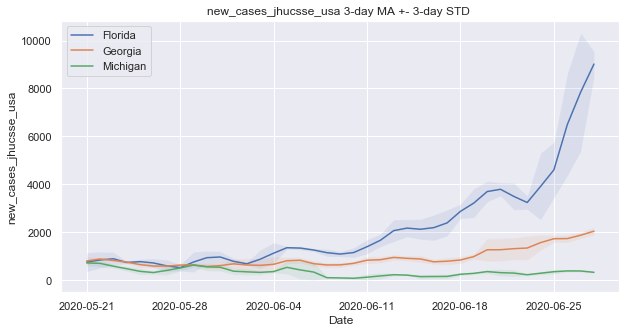

In [36]:
feature_names = ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3')
location_list = ['Florida', 'Georgia', 'Michigan']
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      feature_names, 
                      location_list)
# plt.legend(loc=(1.2,0))

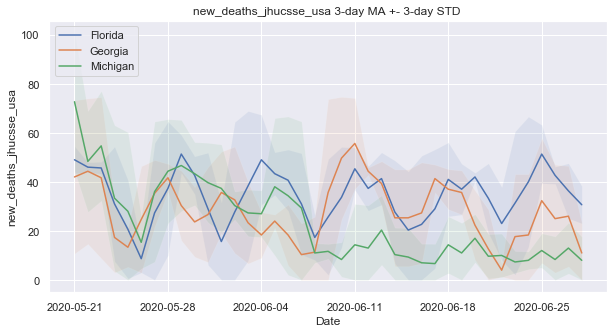

In [37]:
feature_names = ('new_deaths_jhucsse_usa_rolling_mean_3','new_deaths_jhucsse_usa_rolling_std_3')
location_list = ['Florida', 'Georgia', 'Michigan']
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      feature_names, 
                      ['Florida', 'Georgia', 'Michigan'])

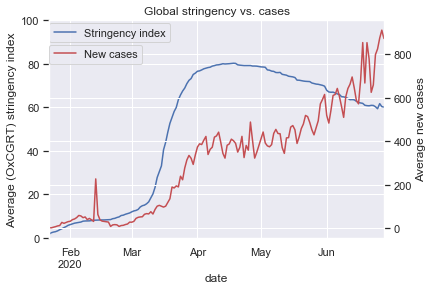

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
data.groupby('date').mean().stringency_index_oxcgrt.plot(ax=ax, label='Stringency index')
data.groupby('date').new_cases_owid.mean().plot(ax=ax2, color='r', label='New cases')
ax.set_ylim([0,100])
ax.set_title('Global stringency vs. cases')
ax.set_ylabel('Average (OxCGRT) stringency index')
ax2.set_ylabel('Average new cases')
ax.legend(loc=(0,0.9))
ax2.legend(loc=(0,0.8))

In [39]:
two_months_ago = time_slice(data, -60, -30)
last_month = time_slice(data, -30, -1)

last_month_new_cases = (last_month[last_month.date == last_month.date.max()].total_cases.reset_index(drop=True) 
- last_month[last_month.date == last_month.date.min()].total_cases.reset_index(drop=True))

two_months_ago_new_cases = (two_months_ago[two_months_ago.date == two_months_ago.date.max()].total_cases.reset_index(drop=True) 
- two_months_ago[two_months_ago.date == two_months_ago.date.min()].total_cases.reset_index(drop=True))

# rate of change of new cases per month  
thirty_day_rate_of_change = last_month_new_cases - two_months_ago_new_cases
# round down small changes to 0. 
thirty_day_rate_of_change[np.abs(thirty_day_rate_of_change)<10] = 0

In [40]:
positive_growth = 100 * (thirty_day_rate_of_change > 0).sum() / len(thirty_day_rate_of_change)
negative_growth =100 * (thirty_day_rate_of_change < 0).sum() / len(thirty_day_rate_of_change)
stationary_growth = 100 * (thirty_day_rate_of_change==0).sum() / len(thirty_day_rate_of_change)
print('Today, %.2f percent of countries have a positive 30-day growth rate' % positive_growth)
print('Today, %.2f percent of countries have a negative 30-day growth rate' % negative_growth)
print('Today, %.2f percent of countries have approximately stationary 30-day growth rate' % stationary_growth)

Today, 52.60 percent of countries have a positive 30-day growth rate
Today, 29.41 percent of countries have a negative 30-day growth rate
Today, 17.99 percent of countries have approximately stationary 30-day growth rate



Time series variables with drift as baseline model : any columns with 'new' (cases, deaths, tests)
Time series variables with naive as baseline model : The complement to the drift baseline variables. 

The "Our World in Data" testing data isn't as reliable as the "Test tracker" testing data. 
This shows why it is important to be careful when selecting which representative from the
set of redundant features to use.


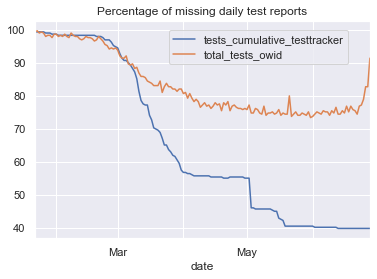

In [41]:
fig, ax = plt.subplots()
(100 * data.set_index(['location', 'date']).isna().groupby(level=1).sum().loc[:, ['tests_cumulative_testtracker', 'total_tests_owid']]
 / data.location.nunique()).plot(ax=ax)
plt.title('Percentage of missing daily test reports')
plt.legend(loc=(0.4,0.8))
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

Summary statistics of the "age" of the pandemic in each country.

In [42]:
print('The statistics of the age of the pandemic in each country, in units of days.\n')
print(today.days_since_first_case.describe())

The statistics of the age of the pandemic in each country, in units of days.

count    289.000000
mean     113.564014
std       19.218866
min       27.000000
25%      103.000000
50%      111.000000
75%      120.000000
max      158.000000
Name: days_since_first_case, dtype: float64


In [43]:
government_responses = pd.concat((data.loc[:, ['location','time_index','days_since_first_case']],
                                  data.loc[:, column_search(data, 'oxcgrt')].drop(
                                      columns=column_search(data, 'flag')).iloc[:,2:10]), axis=1)

In [44]:
countries_with_responses = government_responses.groupby('location').max().dropna()
countries_with_all_responses = (countries_with_responses.iloc[np.where((
    government_responses.groupby('location').max().dropna()==0).sum(1)==0)[0],:])
# ((government_responses.groupby('location').max().dropna()==0).sum(1)) > 0 

In [45]:
responses = pd.Index(['active_pandemic_dates']).append(countries_with_all_responses.columns[2:])

In [46]:
all_responses = government_responses[government_responses.location.isin(countries_with_all_responses.index)]
# all_responses = all_responses#.set_index('time_index')
# all_responses.dropna().replace(to_replace=[0,0.], value=np.nan).dropna(0).groupby('location').time_index.min()#.idxmax()
# all_responses.dropna().replace(to_replace=[0,0.], value=np.nan).dropna(0).groupby('location').time_index.max()

In [47]:
# all_responses
response_ranges = []
for c in all_responses.columns[2:]:
    active_range = all_responses.loc[:, ['time_index','location']+[c]].replace(to_replace=[0,0.], value=np.nan).dropna().groupby('location').time_index
    response_ranges.append([slice(*x) for x in list(zip(active_range.min().values, active_range.max().values+1))])
    
response_slices_df = pd.DataFrame(np.array(response_ranges).transpose(),
                                 index=all_responses.location.unique(), columns=responses)

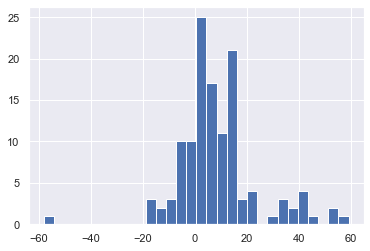

In [48]:
average_response_date = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].mean(1)
average_reaction_times = (average_response_date.astype(int) 
                          - response_slices_df.applymap(lambda x : x.start).active_pandemic_dates)
_ = plt.hist(average_reaction_times, bins=30)

In [49]:
start_dates = response_slices_df.applymap(lambda x : x.start)
stop_dates = response_slices_df.applymap(lambda x : x.stop)
start_dates.columns =[x[0] for x in response_slices_df.columns.str.split('_oxcgrt')]

In [50]:
death_rates = today.total_deaths / today.total_cases
death_rates.index = today.location.values
death_rates = death_rates.dropna()
average_reaction_times = average_reaction_times.dropna()

In [51]:
countries_with_all_average_reaction = average_reaction_times.index.intersection(death_rates.index)
death_rates = 100*death_rates.loc[countries_with_all_average_reaction]
average_reaction_times = average_reaction_times.loc[countries_with_all_average_reaction]

In [52]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(average_reaction_times.values, death_rates.values)

(0.06639203035415003,
 2.587145955857752,
 0.29819253137935486,
 0.000768863428175275,
 0.01924056491204136)

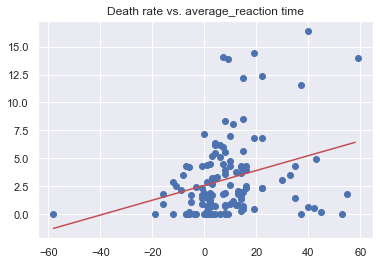

In [53]:
fig, ax = plt.subplots()
ax.scatter(average_reaction_times, 
            death_rates)
ax.plot(np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()),
        slope*np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()) + intercept, color='r')
# ax.set_ylim([-4, 4])
# ax.set_xlim([-4, 4])
ax.set_title('Death rate vs. average_reaction time')
ax.grid(True)
slope, intercept, r_value, p_value, std_err 

Late responders, first government action AFTER first case.

Early responders, first government action BEFORE first case.

In [54]:
date_of_first_response = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].min(1)
date_of_pandemic_start =  response_slices_df.applymap(lambda x : x.start).active_pandemic_dates
minimum_reaction_times = (date_of_first_response-date_of_pandemic_start)

In [55]:
early_responders = average_reaction_times[average_reaction_times<0].index.tolist()
print('\n The early responders:\n')
for i in range(len(early_responders)//5+1):
    print(early_responders[5*i:5*(i+1)])


 The early responders:

['Albania', 'Angola', 'Botswana', 'El Salvador', 'Eswatini']
['Fiji', 'Greenland', 'Guatemala', 'Haiti', 'Kenya']
['Kosovo', 'Kyrgyz Republic', 'Laos', 'Lesotho', 'Libya']
['Madagascar', 'Mongolia', 'Myanmar', 'Papua New Guinea', 'Puerto Rico']
['Rwanda', 'Sierra Leone', 'South Sudan', 'Syria', 'Uganda']
['Zimbabwe']


In [56]:
late_responders = average_reaction_times[average_reaction_times>=0].index.tolist()
print('The late responders:\n')
for i in range(len(late_responders)//5+1):
    print(late_responders[5*i:5*(i+1)])

The late responders:

['Afghanistan', 'Algeria', 'Argentina', 'Austria', 'Azerbaijan']
['Bahrain', 'Bangladesh', 'Barbados', 'Belize', 'Bermuda']
['Bhutan', 'Bolivia', 'Bosnia And Herzegovina', 'Brazil', 'Burkina Faso']
['Cape Verde', 'Chad', 'China', 'Colombia', 'Congo']
['Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Democratic Republic Of Congo']
['Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt']
['Eritrea', 'Ethiopia', 'France', 'Gabon', 'Gambia']
['Georgia', 'Ghana', 'Greece', 'Guinea Bissau', 'Guyana']
['Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq']
['Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica']
['Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Liberia']
['Lithuania', 'Mauritius', 'Mexico', 'Moldova', 'Morocco']
['Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Oman']
['Pakistan', 'Palestine', 'Panama', 'Paraguay', 'Peru']
['Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania']
['Russia', 'San Marino', 'Saudi Arabia', 'Serbia', 'Seychelles']
['Singapo

In [57]:
late_data = data[data.location.isin(late_responders)]
early_data = data[data.location.isin(early_responders)]

early_data_present_day = early_data[early_data.time_index == data.time_index.max()]
late_data_present_day = late_data[late_data.time_index == data.time_index.max()]

d_rate = pd.Series(death_rates, index=data.location.unique())
early_d_rates = d_rate.loc[early_data_present_day.location.unique()]
late_d_rates = d_rate.loc[late_data_present_day.location.unique()]

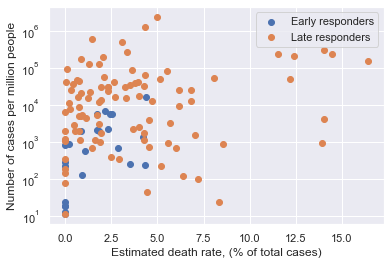

In [58]:
_ = plt.scatter(early_d_rates, early_data_present_day.total_cases_owid.values, label='Early responders')
_ = plt.scatter(late_d_rates, late_data_present_day.total_cases_owid.values, label='Late responders')
_ = plt.xlabel('Estimated death rate, (% of total cases)')
_ = plt.ylabel('Number of cases per million people')
_ = plt.legend()
_ = plt.yscale('log')
# plt.plot(np.sort(death_rate))

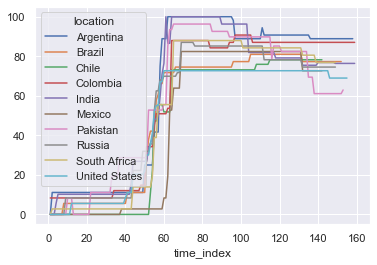

In [59]:
per_country_plot(data[data.location.isin(top_10_locations_most_cases)], 'stringency_index_oxcgrt')